# Homework 4

dataset - !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## Data preparation

* Take a subset of columns
* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

In [3]:
df = pd.read_csv("data.csv")
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [4]:
columns = ['Make', 'Model', 'Engine HP', 'Engine Cylinders', 'Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']

df = df[columns].copy()
df.head()

,Make,Model,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,230.0,6.0,MANUAL,Convertible,28,18,34500


In [6]:
df.columns = df.columns.str.lower().str.replace(" ",'_')

In [7]:
df = df.fillna(0)

In [8]:
mean_price = df['msrp'].mean()
df['above_average'] = (df.msrp >= mean_price).astype(int)

del df['msrp']

In [9]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train['above_average']
del df_test['above_average']
del df_val['above_average']

# Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

Answer -> 'engine_hp' has the highest AUC score with 0.92

Higher AUC score means that feature is more important to include in the model

In [11]:
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = list(df.dtypes[df.dtypes == 'object'].index)

print(f"Numerical-> {numerical}")
print(f'Categorical -> {categorical}')

Numerical-> ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
Categorical -> ['make', 'model', 'transmission_type', 'vehicle_style']


In [14]:
for n in numerical:
    auc = roc_auc_score(y_train, df_train[n])
    if  auc <0.5:
        auc = roc_auc_score(y_train, -df_train[n])

    print("%16s, %.3f" % (n,auc))

       engine_hp, 0.917
engine_cylinders, 0.766
     highway_mpg, 0.633
        city_mpg, 0.673


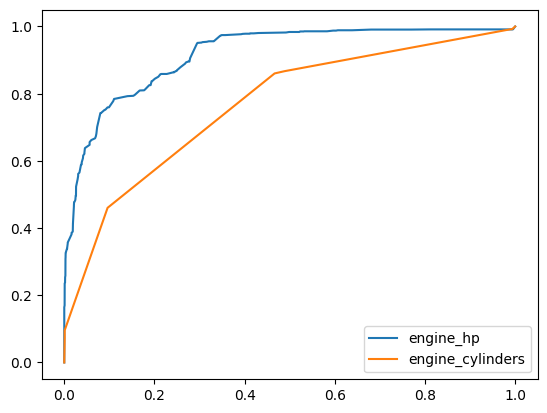

In [22]:
#engine hp
fpr, tpr, _ = roc_curve(y_train,df_train.engine_hp)
plt.plot(fpr, tpr, label = 'engine_hp')

#egnine cylinders
fpr, tpr, _ = roc_curve(y_train,df_train.engine_cylinders)
plt.plot(fpr, tpr, label = 'engine_cylinders')

plt.legend()

# Question 2

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) What's the AUC of this model on the validation dataset? (round to 3 digits)

0.678

0.779

0.878

0.979

Answer -> 0.979 approx

In [28]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

In [29]:
roc_auc_score(y_val, y_pred)

0.9813431779873112

# Question 3
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01

For each threshold, compute precision and recall
Plot them


At which threshold precision and recall curves intersect?

0.28
0.48
0.68
0.88

Answer - `0.48`

In [31]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores

In [34]:
df_scores = confusion_matrix_dataframe(y_val,y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,654,1729,0,0
10,0.1,646,348,8,1381
20,0.2,628,208,26,1521
30,0.3,607,131,47,1598
40,0.4,597,86,57,1643
50,0.5,575,64,79,1665
60,0.6,553,46,101,1683
70,0.7,514,26,140,1703
80,0.8,461,12,193,1717
90,0.9,372,3,282,1726


In [35]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores[::10]

,threshold,tp,fp,fn,tn,p,r
0,0.0,654,1729,0,0,0.274444,1.000000
10,0.1,646,348,8,1381,0.649899,0.987768
20,0.2,628,208,26,1521,0.751196,0.960245
30,0.3,607,131,47,1598,0.822493,0.928135
40,0.4,597,86,57,1643,0.874085,0.912844
50,0.5,575,64,79,1665,0.899844,0.879205
60,0.6,553,46,101,1683,0.923205,0.845566
70,0.7,514,26,140,1703,0.951852,0.785933
80,0.8,461,12,193,1717,0.974630,0.704893
90,0.9,372,3,282,1726,0.992000,0.568807


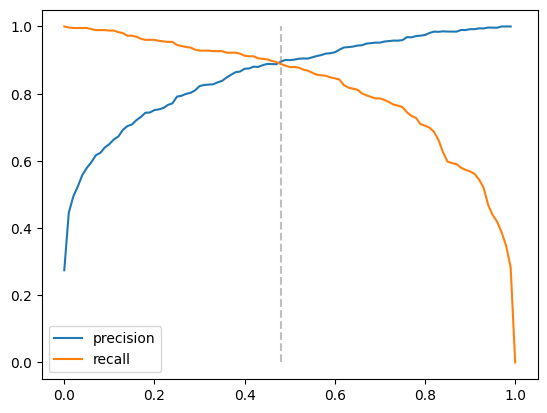

In [48]:
plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

plt.vlines(0.48, 0, 1, color='grey', linestyle='--', alpha=0.5)

plt.legend()
plt.show()

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

 
Where 
 is precision and 
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01


At which threshold F1 is maximal?

0.12
0.32
0.52
0.72

Answer - 0.52

In [44]:
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [45]:
df_scores.f1[::10]

0      0.430688
10     0.783981
20     0.842953
30     0.872126
40     0.893044
50     0.889404
60     0.882682
70     0.860972
80     0.818101
90     0.723032
100         NaN
Name: f1, dtype: float64

In [46]:
df_scores.loc[df_scores.f1.argmax()]

threshold       0.420000
tp            596.000000
fp             81.000000
fn             58.000000
tn           1648.000000
p               0.880355
r               0.911315
f1              0.895567
Name: 42, dtype: float64

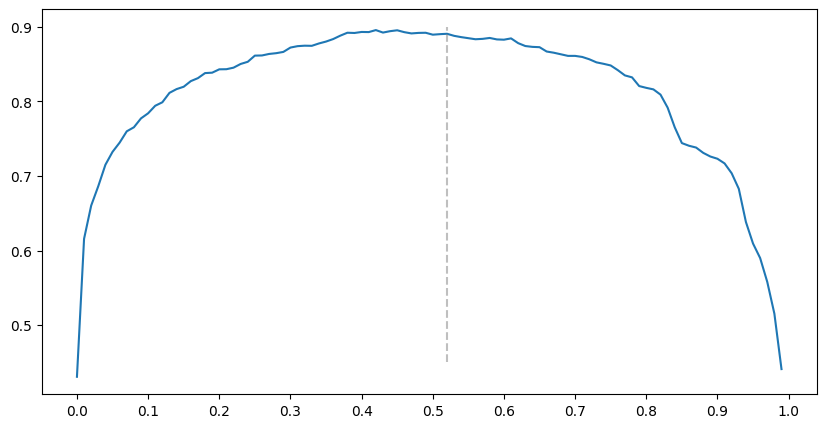

In [47]:
plt.figure(figsize=(10, 5))

plt.plot(df_scores.threshold, df_scores.f1)
plt.vlines(0.52, 0.45, 0.9, color='grey', linestyle='--', alpha=0.5)

plt.xticks(np.linspace(0, 1, 11))
plt.show()

# Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

In [49]:
from sklearn.model_selection import KFold

In [50]:
columns = list(df.columns)
columns.remove('above_average')
columns

['make',
 'model',
 'engine_hp',
 'engine_cylinders',
 'transmission_type',
 'vehicle_style',
 'highway_mpg',
 'city_mpg']

In [55]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [56]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.984 +- 0.002


# Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 0.5, 10]

Initialize KFold with the same parameters as previously

Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


In [57]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 0.938 +- 0.002
C= 0.1, 0.973 +- 0.003
C= 0.5, 0.982 +- 0.003
C=  10, 0.987 +- 0.002
